# Biological insights through omics data integration
Elad Noor, Sarah Cherkaoui, Uwe Sauer

In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from Bio import Entrez
import seaborn as sns
sns.set('paper')
Entrez.email = 'noor@imsb.biol.ethz.ch'

def count(query, year=None):
    if year is None:
        handle = Entrez.esearch(db='pubmed', 
                                rettype='count',
                                retmode='xml',
                                mindate='2000',
                                maxdate='2018',
                                term=query)
    else:
        handle = Entrez.esearch(db='pubmed', 
                                rettype='count',
                                retmode='xml', 
                                datetype='edat',
                                mindate='%d' % year,
                                maxdate='%d' % year,
                                term=query)
        
    results = Entrez.read(handle)
    return int(results['Count'])

def counts_per_year(query, minyear=2000, maxyear=2018):
    data = []
    for year in range(minyear, maxyear+1):
        n_papers = count(query, year=year)
        data.append((year, n_papers))
    return pd.DataFrame(columns=['year', 'n_papers'], data=data).set_index('year')

## Figure 1A - single omics counts

In [ ]:
metab_df = counts_per_year('metabolome or metabolomic')
metab_df.rename(columns={'n_papers': 'metabolomics'}, inplace=True)

gene_df = counts_per_year('genome or genomic')
gene_df.rename(columns={'n_papers': 'genomics'}, inplace=True)

transcript_df = counts_per_year('transcriptome or transcriptomic or rnaseq or microarray')
transcript_df.rename(columns={'n_papers': 'transcriptomics'}, inplace=True)

protein_df = counts_per_year('proteome or proteomic')
protein_df.rename(columns={'n_papers': 'proteomics'}, inplace=True)

omic_df = pd.concat([gene_df, protein_df, transcript_df, metab_df], axis=1)

In [68]:
import matplotlib.style
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = 'cabin'
mpl.rcParams['figure.figsize'] = [4.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 10


fig, axs = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.02)
omic_df.plot(ax=axs[0], linewidth=2, legend=False)
omic_df.plot(ax=axs[1], linewidth=2, legend=False)
axs[0].set_ylim(30000, 75000)
axs[0].xaxis.grid(False)
axs[0].spines['bottom'].set_visible(False)
axs[1].set_ylim(0, 16000)
axs[1].set_ylabel('Number of publications')
axs[1].set_xlabel('Year of Publication')
axs[1].spines['top'].set_visible(False)
axs[1].set_xticks(range(2002, 2019, 4))
axs[1].set_xticklabels(labels=map(str, range(2002, 2019, 4)))
axs[1].set_yticks([5000, 10000, 15000])
axs[1].set_yticklabels(labels=map(str, [5000, 10000, 15000]))
axs[1].xaxis.grid(False)
axs[1].text(2012, 5600, "Metabolomics", rotation=20)
axs[1].text(2013, 11000, "Proteomics", rotation=15)
axs[1].text(2009.6, 14000, "Transcriptomics", rotation=35)
axs[0].text(2009, 64000, "Genomics", rotation=35)
fig.tight_layout()
fig.savefig('figures/fig1a.svg', dpi=500)

## Figure 1B - Venn diagram

In [5]:
omics = ['(genomic or genome)', '(metabolomic or metabolome)', '(transcriptome or transcriptomic or rnaseq or microarray)', '(proteomic or proteome)']
dfs = []
for boolfunc in itertools.product([0, 1], repeat=4):
    if 1 not in boolfunc:
        continue
    prefixes = ['' if b == 1 else 'NOT ' for b in boolfunc]
    query = '(((' + ') '.join(map(''.join, sorted(zip(prefixes, omics))))
    multi_df = counts_per_year(query)
    for b, o in zip(boolfunc, omics):
        multi_df[o] = b
    dfs.append(multi_df)
multi_df = pd.concat(dfs, axis=0)

# Values for the Venn diagram (in the years 2000-2018)
venn_df = multi_df.groupby(omics).sum().reset_index()
venn_df

(genomic or genome)  (metabolomic or metabolome)  \
0                     0                            0   
1                     0                            0   
2                     0                            0   
3                     0                            1   
4                     0                            1   
5                     0                            1   
6                     0                            1   
7                     1                            0   
8                     1                            0   
9                     1                            0   
10                    1                            0   
11                    1                            1   
12                    1                            1   
13                    1                            1   
14                    1                            1   

    (transcriptome or transcriptomic or rnaseq or microarray)  \
0                                                   0           
1                                                   1           
2                                                   1           
3                                                   0           
4                                                   0           
5                                                   1           
6                                                   1           
7                                                   0           
8                                                   0           
9                                                   1           
10                                                  1           
11                                                  0           
12                                                  0           
13                                                  1           
14                                                  1           

    (proteomic or proteome)  n_papers  
0                         1     42914  
1                         0     76130  
2                         1      2923  
3                         0     19900  
4                         1      2227  
5                         0       883  
6                         1       275  
7                         0    896514  
8                         1     56512  
9                         0     57349  
10                        1      6233  
11                        0      3212  
12                        1      2792  
13                        0       599  
14                        1       781

In [55]:
total = venn_df['n_papers'].sum()
single = venn_df[venn_df.drop('n_papers', axis=1).sum(1) == 1]['n_papers'].sum()
multi = venn_df[venn_df.drop('n_papers', axis=1).sum(1) > 1]['n_papers'].sum()
print('Single-omics: %d (%.1f%%)' % (single, 100.0*single/total))
print('Multi-omics: %d (%.1f%%)' % (multi, 100.0*multi/total))
print('Total: %d (%.1f%%)' % (total, 100.0))

Single-omics: 1035458 (88.6%)
Multi-omics: 133786 (11.4%)
Total: 1169244 (100.0%)


## Figure 1C: multi-omics versus single omics

In [56]:
omics3 = ['(metabolomic or metabolome)', '(transcriptome or transcriptomic or rnaseq or microarray)', '(proteomic or proteome)']
_dfs = []
for boolfunc in itertools.product([0, 1], repeat=len(omics3)):
    if 1 not in boolfunc:
        continue
    prefixes = ['' if b == 1 else 'NOT ' for b in boolfunc]
    query = '(((' + ') '.join(map(''.join, sorted(zip(prefixes, omics3))))
    _df = counts_per_year(query)
    for b, o in zip(boolfunc, omics3):
        _df[o] = b
    _dfs.append(_df)
multi3_df = pd.concat(_dfs, axis=0)

tmp_df = multi3_df.copy()
tmp_df['multi'] = multi3_df[omics3].sum(1) > 1
tmp_df = tmp_df.groupby(['multi', 'year']).sum()['n_papers'].reset_index().pivot('year', 'multi')
tmp_df['% of multi-omics papers'] = 100 * tmp_df[('n_papers', True)] / tmp_df.sum(axis=1)

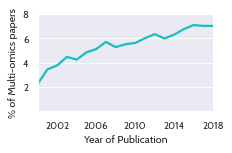

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
tmp_df['% of multi-omics papers'].plot(ax=ax, linewidth=2, color='#1bbdc2')
ax.set_xlabel('Year of Publication')
ax.set_ylabel('% of Multi-omics papers')
ax.set_ylim(0, 8)
ax.set_xticks(range(2002, 2019, 4))
ax.set_xticklabels(labels=map(str, range(2002, 2019, 4)))
ax.set_yticks([2, 4, 6, 8])
ax.set_yticklabels(labels=map(str, [2, 4, 6, 8]))
ax.xaxis.grid(False)
#ax.set_yscale('log')
fig.tight_layout()
fig.savefig('figures/fig1c.svg', dpi=500)